# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer(as_frame=True)
df_cancer = data.frame
df_cancer.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
df_cancer.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

# Analisis del Dataset

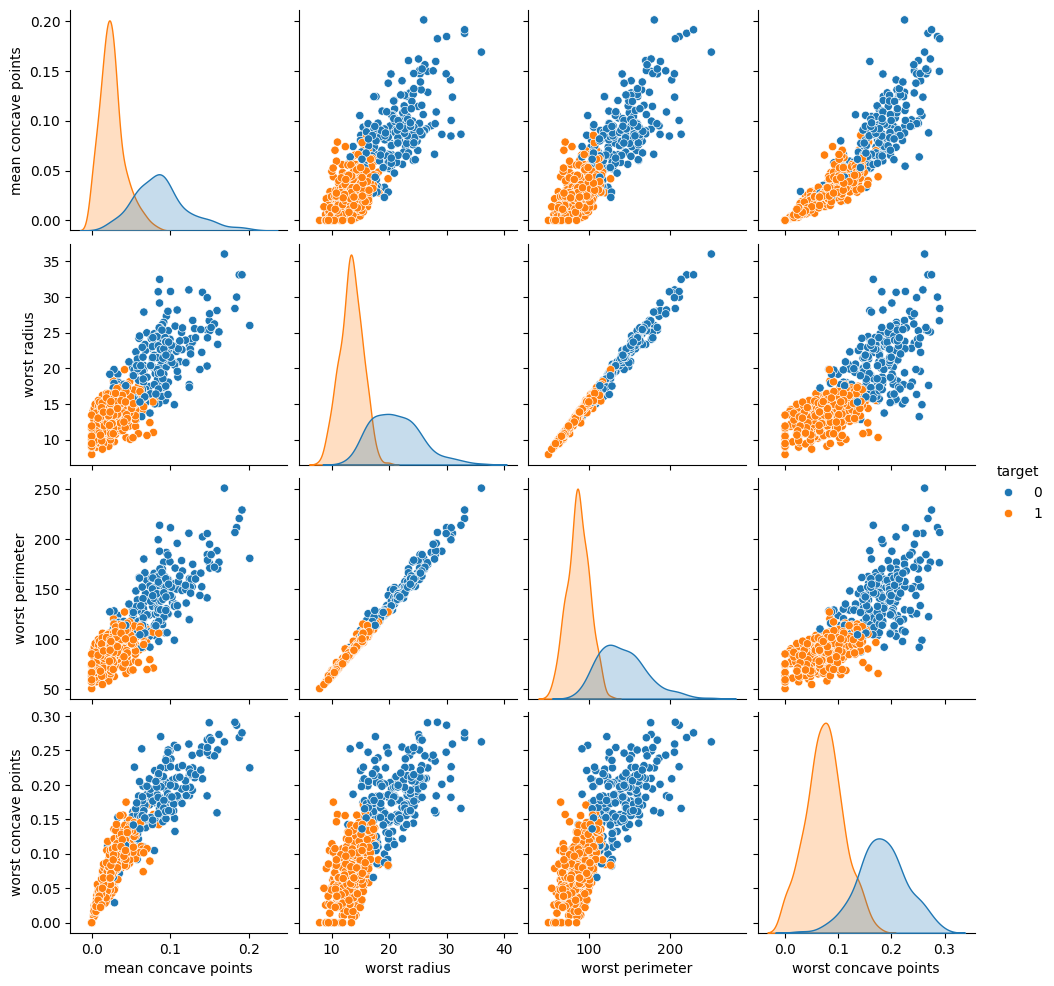

In [4]:
correlation = df_cancer.corr()
threshold = 0.75
filter = np.abs(correlation["target"]) > threshold
correlation_features = correlation.columns[filter].tolist()
sns.pairplot(df_cancer[correlation_features], diag_kind = "kde",  hue="target")
plt.show()

# Preprocesamiento de datos

In [5]:
# Hacemos el Split 70-30 para train-test
X = df_cancer.drop(columns="target")
y = df_cancer["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=42)

In [ ]:
#Pipeline LogisticRegression basico
pl_logreg = Pipeline([
    ("selector", ColumnTransformer([("selector", "passthrough", ['mean concave points', 'worst radius', 'worst perimeter', 'worst concave points'])], remainder="drop")),
    ('classifier', LogisticRegression())
])

pl_logreg.fit(X_train, y_train)

,steps,"[('selector', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('selector', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [7]:
y_pred_lg = pl_logreg.predict(X_test)

# Comparamos por Curva ROC

In [8]:
def graficarCurvaRoc( y_pred, model ):
  fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
  auc = metrics.roc_auc_score(y_test, y_pred)
  # Graficamos
  plt.plot(fpr,tpr,label= model +" AUC="+str(round(auc,4))) #,label= "AUC="+str(auc))
  plt.legend(loc=4, fontsize=12)
  return auc

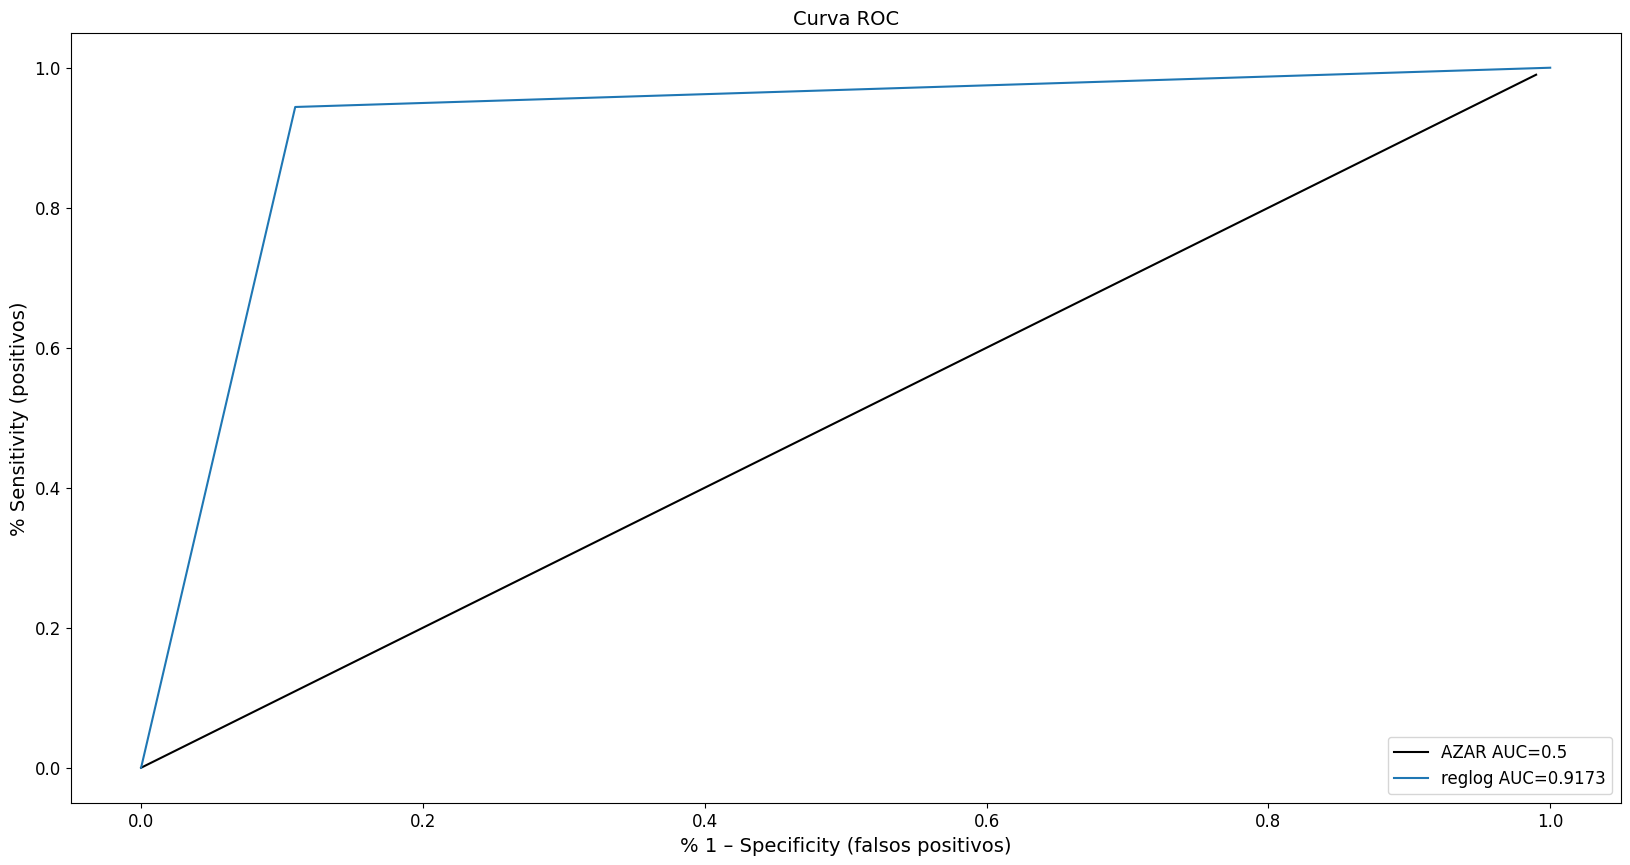

In [9]:
# Inicializamos los labels del gráfico
plt.figure(figsize=(20, 10))
plt.xlabel('% 1 – Specificity (falsos positivos)', fontsize=14)
plt.ylabel('% Sensitivity (positivos)', fontsize=14)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR AUC=0.5",color="black")

modelos = {'reglog':y_pred_lg}
areas = []
for pred in modelos:
    auc = graficarCurvaRoc( modelos[pred] , pred )
    areas.append( (pred, auc) )
areas = pd.DataFrame(areas, columns=['model','auc'])

# Agregamos el titulo y configuro el tamaño de letra
plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12);
plt.show()

In [10]:
areas.sort_values('auc', ascending=False)

,model,auc
0,reglog,0.917275


# Ejercicio
### Analisis
- Averiguar distribución de la variable target.
- Graficar Heatmap de la correlacion entre variables numericas y el target.
### Evaluacion de Modelos
- Crear Pipelines para otros modelos (arbol, bayes y knn )
- Comparar los resultados por sus curvas ROC
- ¿Mejoran los modelos con más columnas? (modificando el step de selector del pipeline)
- ¿Mejoran los modelos escalando las variables? (agregando un step de escalado a los pipelines)
### Fine-tunning
- Elegir uno de los modelos y optimizarlo con gridsearchCV